In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import phik
from phik import resources
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import random
from helper import *
from plots import *
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer


In [3]:
df = pd.read_csv(r"d:\dowload2\car_price_prediction.csv\car_price_prediction.csv")
print(df.head().to_string())

         ID  Price  Levy Manufacturer    Model  Prod. year   Category Leather interior Fuel type Engine volume    Mileage  Cylinders Gear box type Drive wheels   Doors             Wheel   Color  Airbags
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep              Yes    Hybrid           3.5  186005 km        6.0     Automatic          4x4  04-May        Left wheel  Silver       12
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep               No    Petrol             3  192000 km        6.0     Tiptronic          4x4  04-May        Left wheel   Black        8
2  45774419   8467     -        HONDA      FIT        2006  Hatchback               No    Petrol           1.3  200000 km        4.0      Variator        Front  04-May  Right-hand drive   Black        2
3  45769185   3607   862         FORD   Escape        2011       Jeep              Yes    Hybrid           2.5  168966 km        4.0     Automatic          4x4  04-May        Left wheel   

In [4]:


# Вывод метрик 
def mean_absolute_percentage_error(y_true, y_pred):
    """Средняя абсолютная процентная ошибка"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def symmetric_mape(y_true, y_pred):
    """Симметричная MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# --- основная функция ---
def evaluate_models_cv_regression(models, X, y, preprocessor=None, cv=5, seed=None, log=False):
    """
    Кросс-валидация регрессионных моделей с возможностью логарифмирования таргета.
    Вычисляет метрики в логарифмическом и реальном масштабе (если log=True).
    Добавлены MAPE и SMAPE для бизнес-интерпретации.
    """
    all_metrics = {}

    scoring = {
        'r2': 'r2',
        'neg_mean_squared_error': 'neg_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
    }

    # Преобразуем таргет, если log=True
    y_to_use = np.log1p(y) if log else y

    for name, model in models:
        print(f"\n{'='*60}\nКросс-валидация модели: {name}\n{'='*60}")
        if seed is not None and hasattr(model, 'random_state'):
            model.set_params(random_state=seed)

        pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)]) if preprocessor else model

        cv_results = cross_validate(
            pipeline,
            X,
            y_to_use,
            cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

        metrics_mean = {metric.replace("test_", ""): np.mean(values)
                        for metric, values in cv_results.items()
                        if metric.startswith("test_")}

        # --- если логарифмируем ---
        if log:
            y_pred_log = cross_val_predict(pipeline, X, y_to_use, cv=cv, n_jobs=-1)
            y_pred_real = np.expm1(y_pred_log)
            y_real = np.expm1(y_to_use)

            MAE_real = mean_absolute_error(y_real, y_pred_real)
            MSE_real = mean_squared_error(y_real, y_pred_real)
            RMSE_real = np.sqrt(MSE_real)
            R2_real = r2_score(y_real, y_pred_real)

            MAPE_real = mean_absolute_percentage_error(y_real, y_pred_real)
            SMAPE_real = symmetric_mape(y_real, y_pred_real)

            metrics_mean.update({
                'MAE_real': MAE_real,
                'MSE_real': MSE_real,
                'RMSE_real': RMSE_real,
                'R2_real': R2_real,
                'MAPE_real': MAPE_real,
                'SMAPE_real': SMAPE_real
            })

        all_metrics[name] = metrics_mean

        # --- вывод ---
        print(f"R2 (log):   {metrics_mean['r2']:.4f}")
        print(f"MSE (log):  {-metrics_mean['neg_mean_squared_error']:.4f}")
        print(f"MAE (log):  {-metrics_mean['neg_mean_absolute_error']:.4f}")
        print(f"RMSE (log): {-metrics_mean['neg_root_mean_squared_error']:.4f}")

        if log:
            print(f"R2 (real):   {metrics_mean['R2_real']:.4f}")
            print(f"MSE (real):  {metrics_mean['MSE_real']:.4f}")
            print(f"MAE (real):  {metrics_mean['MAE_real']:.4f}")
            print(f"RMSE (real): {metrics_mean['RMSE_real']:.4f}")
            print(f"MAPE (real): {metrics_mean['MAPE_real']:.2f}%")
            print(f"SMAPE (real): {metrics_mean['SMAPE_real']:.2f}%")

    # --- итоговая таблица ---
    df_results = pd.DataFrame(all_metrics).T
    df_results = df_results.rename(columns={
        'r2': 'R2_log',
        'neg_mean_squared_error': 'MSE_log',
        'neg_mean_absolute_error': 'MAE_log',
        'neg_root_mean_squared_error': 'RMSE_log'
    }).sort_values(by='R2_log', ascending=False)

    print("\n=== Сводная таблица метрик (усреднённые по CV) ===")
    print(df_results.to_string(float_format="%.4f"))

    return df_results


In [5]:
#Функция для сравнения метрик между разными моделями
def compare_regression_metrics(df1, df2, name1="Variant 1", name2="Variant 2"):
    """
    Сравнивает результаты метрик регрессии для двух наборов моделей.
    
    Параметры:
        df1, df2: pd.DataFrame с метриками (индекс = названия моделей)
        name1, name2: имена вариантов для вывода
    
    Возвращает:
        pd.DataFrame с разницей метрик (df2 - df1)
    """
    # Проверяем, что модели совпадают
    if not all(df1.index == df2.index):
        raise ValueError("Индексы моделей в df1 и df2 должны совпадать")

    # Разница метрик
    diff = df2 - df1

    # Добавляем подписи
    diff.index.name = "Model"
    diff = diff.rename(columns=lambda x: f"Δ{x} ({name2}-{name1})")

    print(f"\n=== Сравнение метрик: {name2} против {name1} ===")
    print(diff.to_string(float_format="%.4f"))

    return diff


In [6]:
SEED = 42

In [7]:
df.info()#увидели что нет пропусков в данных и типы всех объектов                                                                                                                                                                                                                                                                                                                                                                                                                                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [8]:
df['Price'].max()

np.int64(26307500)

In [9]:
df.describe()#посмотрели больше данных про числовые признаки                                                                                                                                                                                                                                               

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [10]:
df.duplicated().sum()#Нашли 313 дубликатов

np.int64(313)

In [11]:
df = df.drop_duplicates()#удалили дубликаты тк они нам не нужны и могут плохо повлиять на модель
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  object 
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  object 
 10  Mileage           18924 non-null  object 
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Doors             18924 non-null  object 
 15  Wheel             18924 non-null  object 
 16  Color             18924 non-null  object 
 17

In [12]:
# Регулярное выражение: оставляем только буквы и символы после цифр
suffixes = df['Mileage'].str.replace(r'\d+', '', regex=True).str.strip()
print(suffixes.unique())


['km']


In [13]:
df['Mileage'] = df['Mileage'].str.replace(' km', '', regex=False).str.replace(' ', '', regex=False).astype(int)
#Перевели признак мили в числовой формат


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  object 
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  object 
 10  Mileage           18924 non-null  int64  
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Doors             18924 non-null  object 
 15  Wheel             18924 non-null  object 
 16  Color             18924 non-null  object 
 17

In [15]:
df['Levy'].replace('-', '0', inplace=True)

C:\Users\dima2\AppData\Local\Temp\ipykernel_16044\1081046789.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Levy'].replace('-', '0', inplace=True)


In [16]:
df['Levy']=df['Levy'].astype(int)#Перевели Levy в числовой признак тк оне таким и является

In [14]:
df['Engine volume']=df['Engine volume'].astype(float)

ValueError: could not convert string to float: '2.0 Turbo'

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  int64  
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  object 
 10  Mileage           18924 non-null  int64  
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Doors             18924 non-null  object 
 15  Wheel             18924 non-null  object 
 16  Color             18924 non-null  object 
 17

In [18]:
len(df[df['Price']<0])#Проверяем на корректность данных некоторые признаки

0

In [19]:
len(df[df['Airbags']<0])

0

In [20]:
len(df[df['Cylinders']<0])

0

In [21]:
df['Fuel type'].value_counts()

Fuel type
Petrol            9944
Diesel            4001
Hybrid            3539
LPG                885
CNG                469
Plug-in Hybrid      85
Hydrogen             1
Name: count, dtype: int64

In [22]:
df['Wheel'].value_counts()

Wheel
Left wheel          17471
Right-hand drive     1453
Name: count, dtype: int64

In [23]:
df.drop('ID', inplace=True, axis=1)#удаляем признак id тк он не несет практической значимости

In [24]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include='object').columns

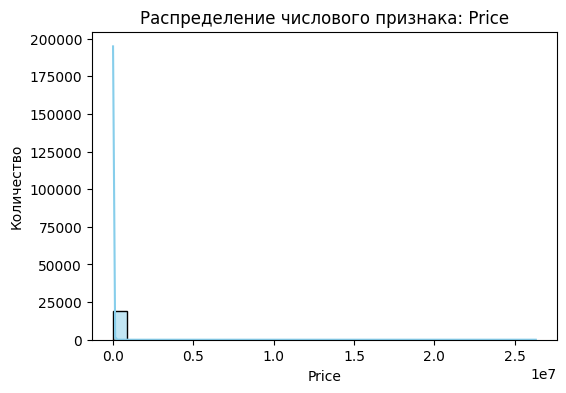

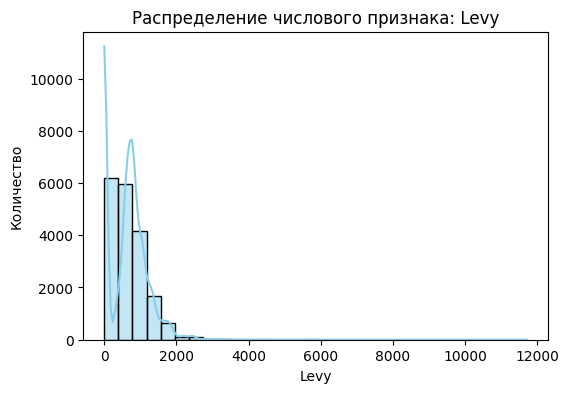

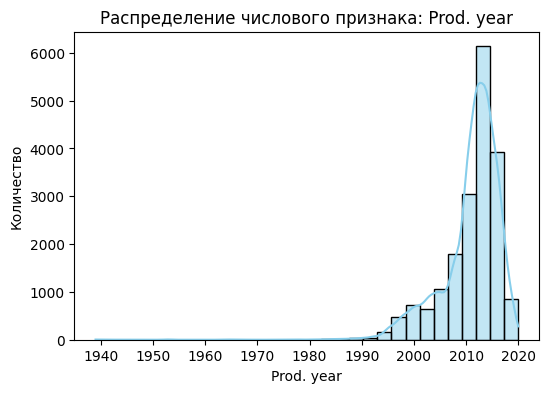

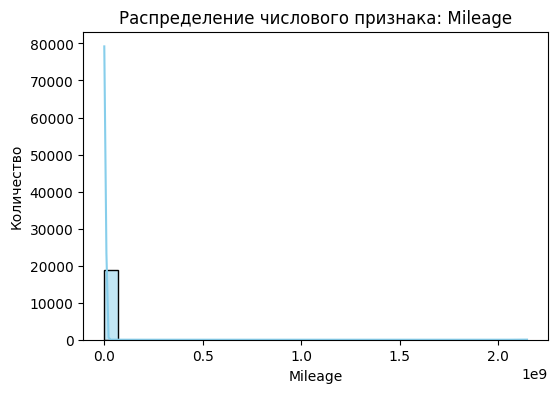

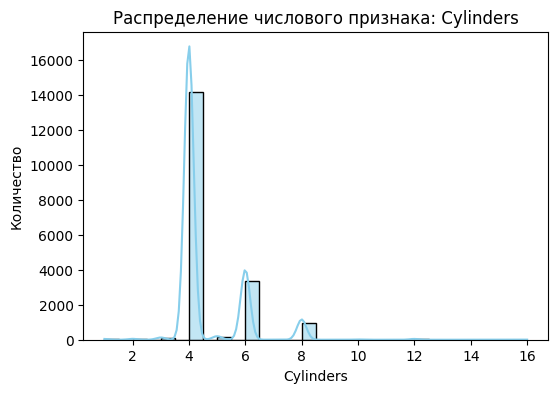

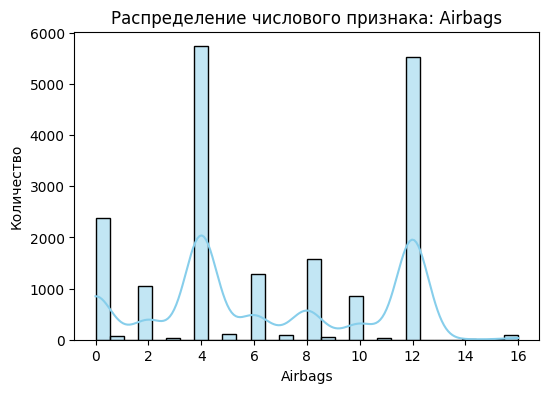

In [20]:
#cтроим распределения числовых признаков
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Распределение числового признака: {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.show()


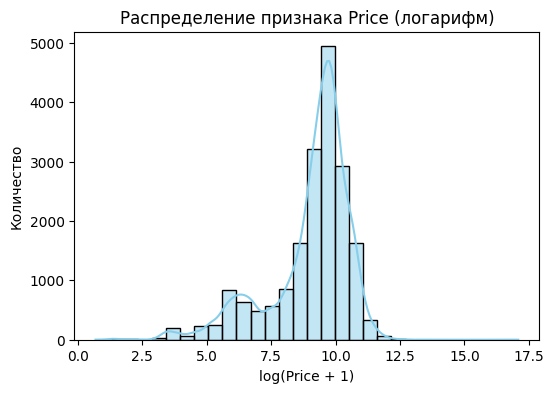

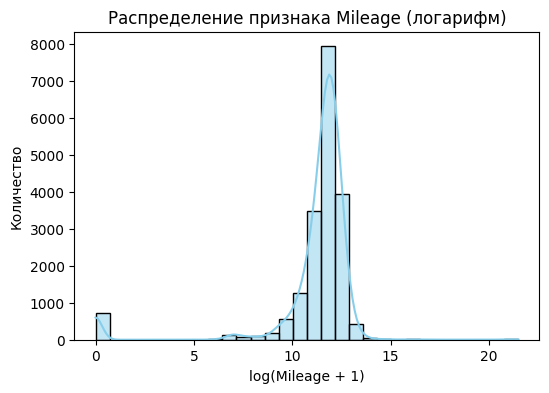

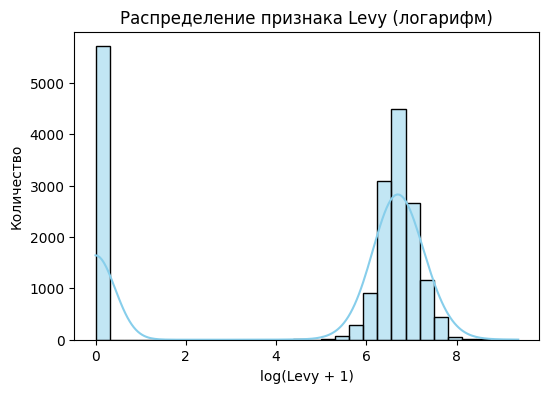

In [21]:
for col in ['Price', 'Mileage', 'Levy']:
    plt.figure(figsize=(6,4))
    sns.histplot(np.log1p(df[col]), kde=True, bins=30, color='skyblue')
    plt.title(f'Распределение признака {col} (логарифм)')
    plt.xlabel(f'log({col} + 1)')
    plt.ylabel('Количество')
    plt.show()
#Построили график через логарифм тк у цены слишком большой разброс значений

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


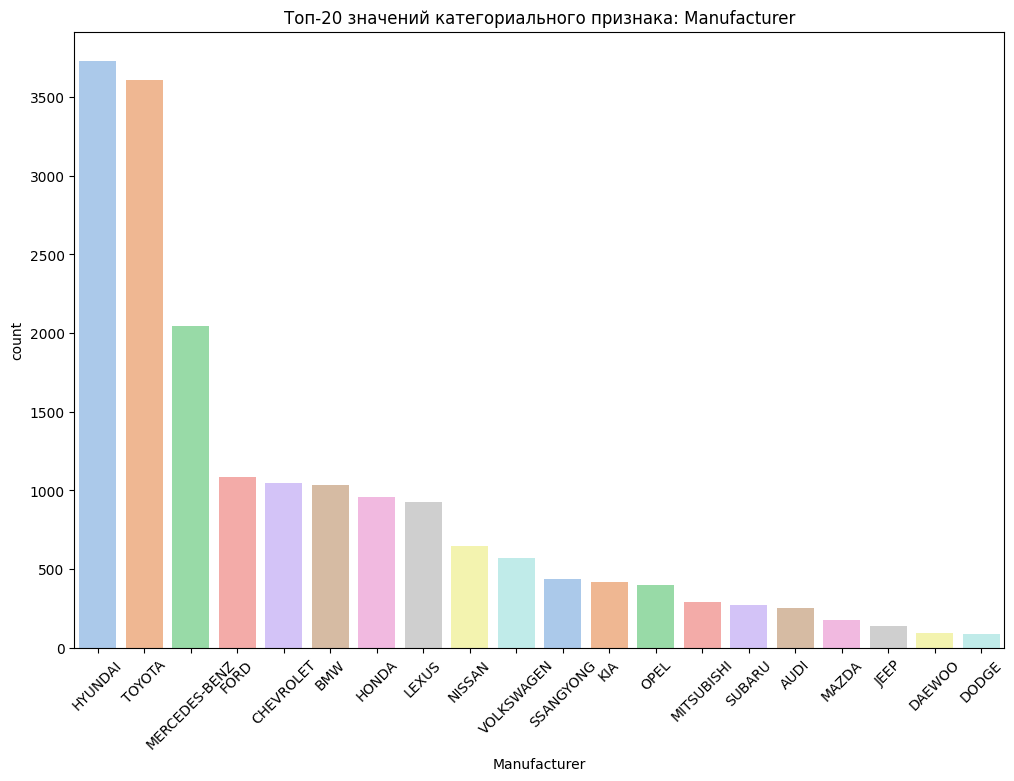

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


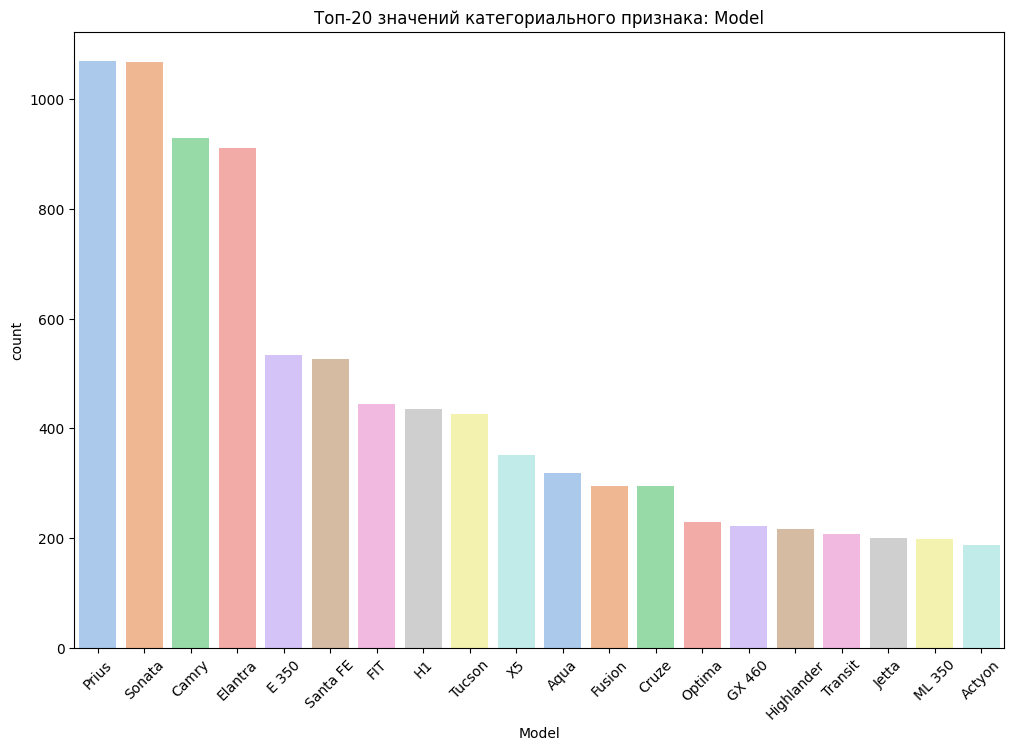

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


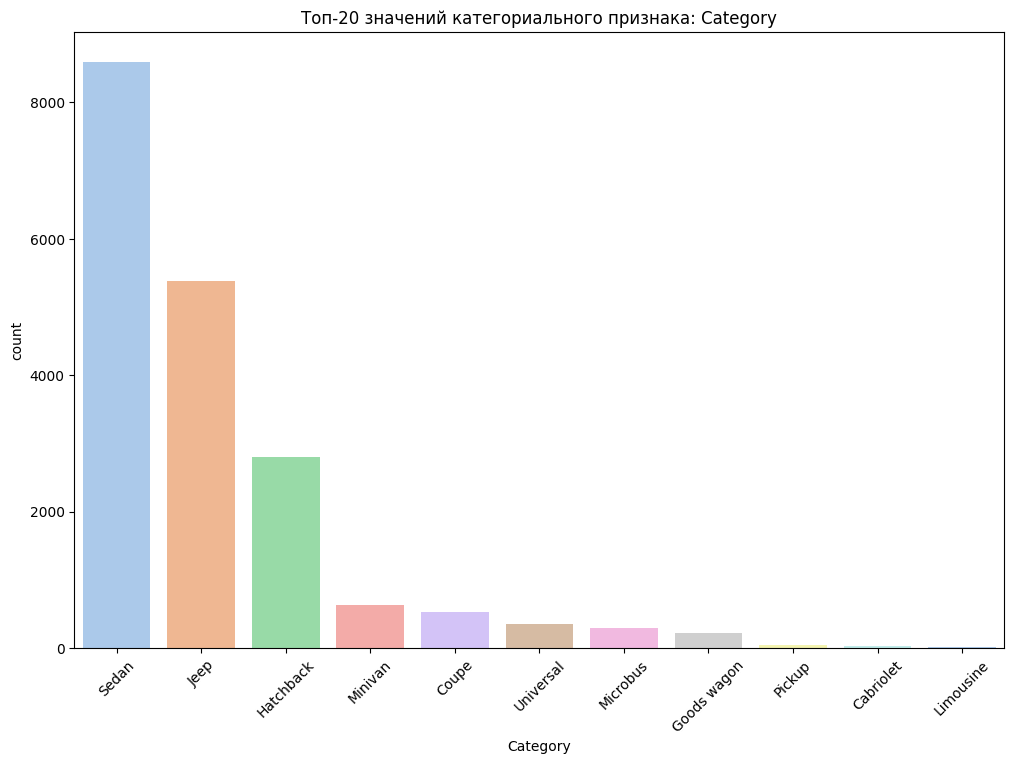

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


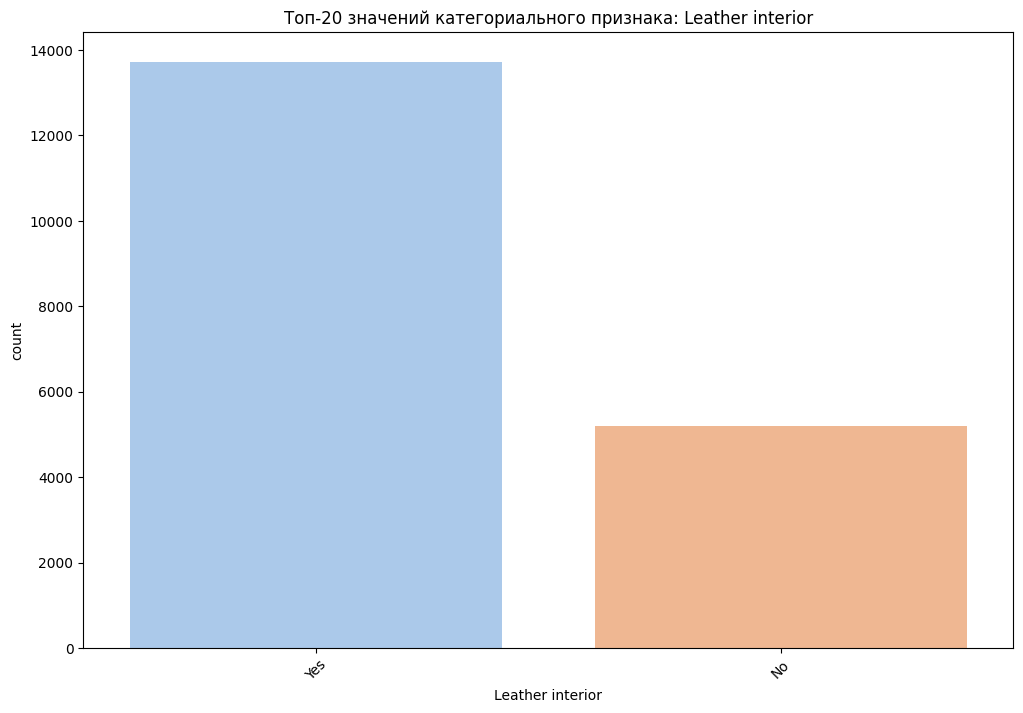

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


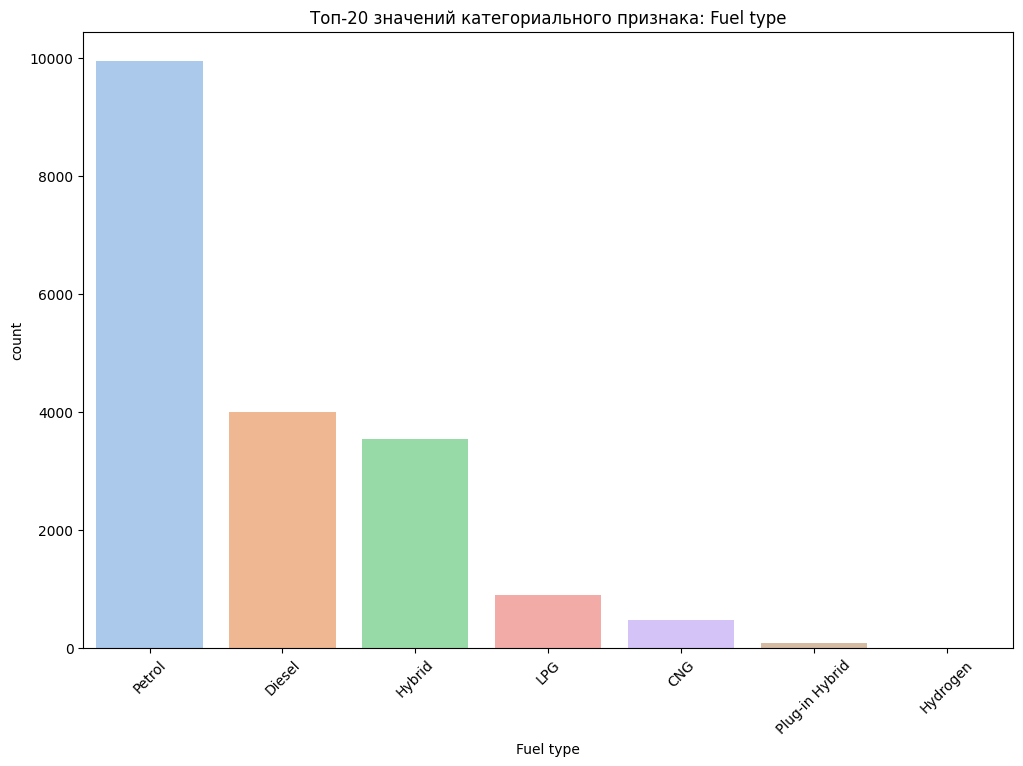

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


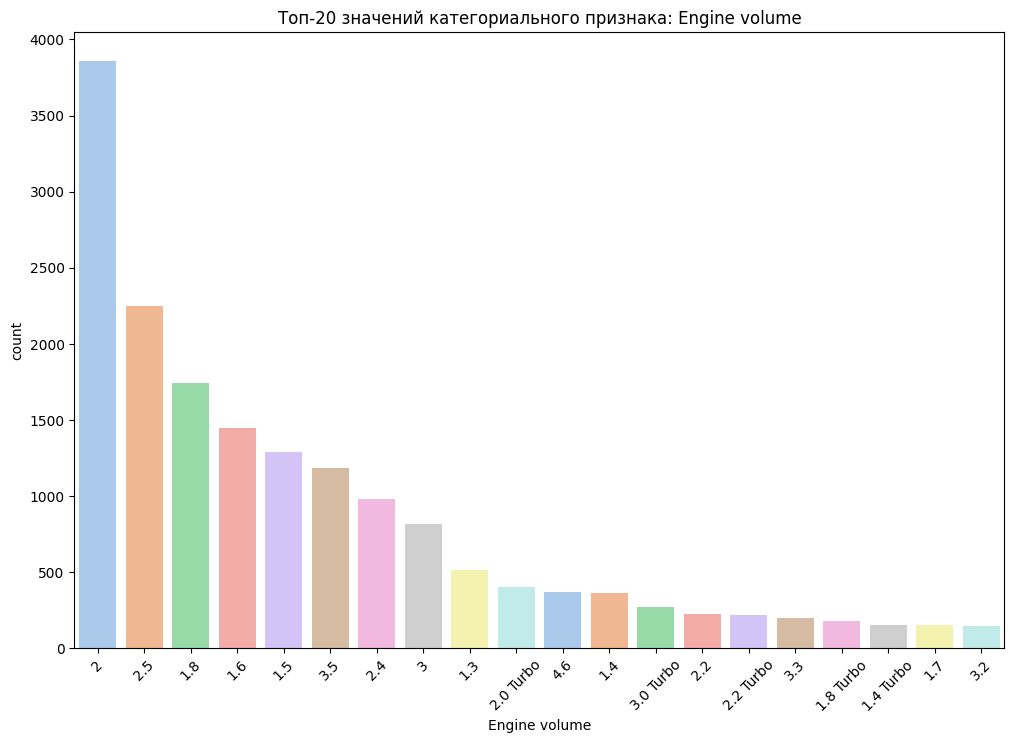

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


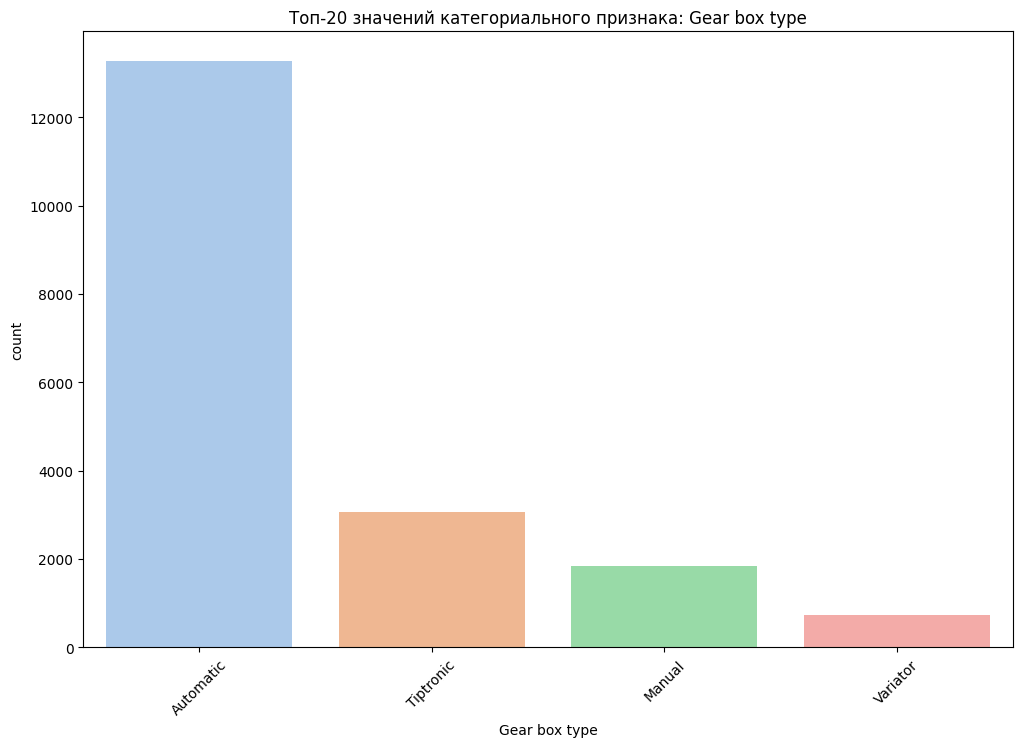

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


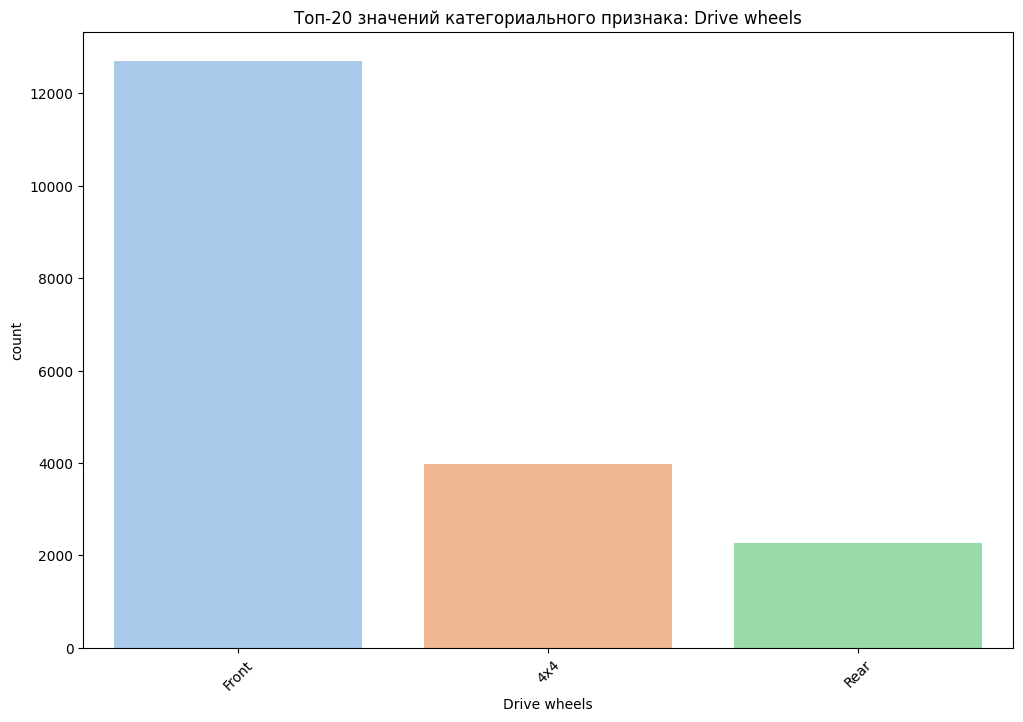

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


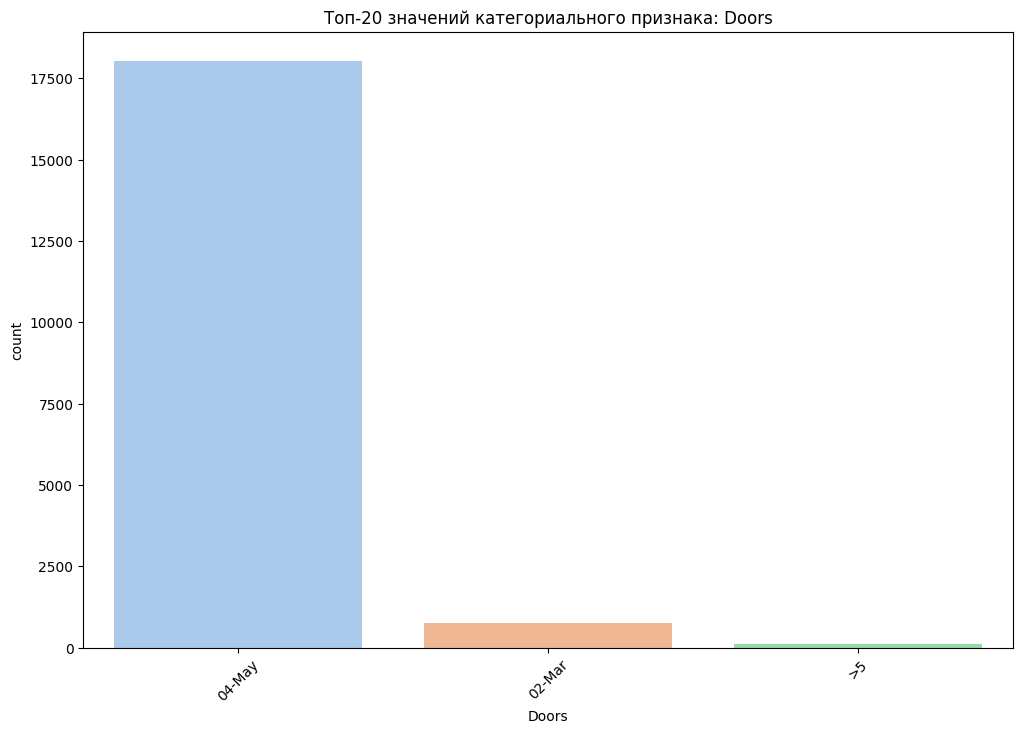

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


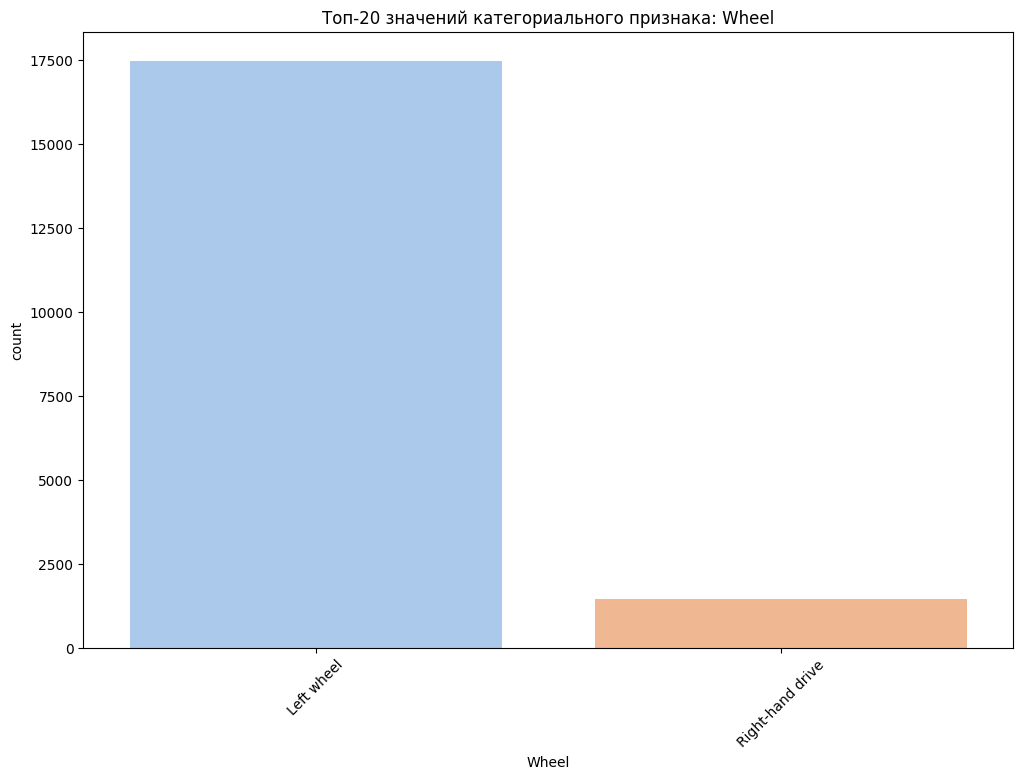

C:\Users\dima2\AppData\Local\Temp\ipykernel_14448\2614177763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


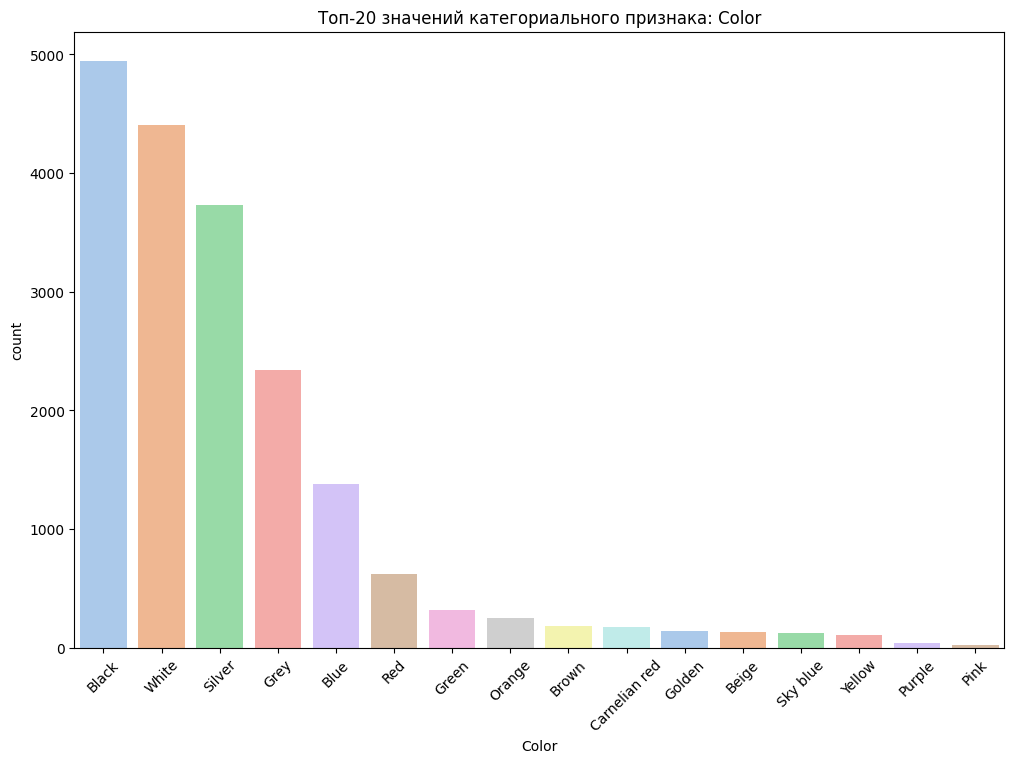

In [ ]:
top_n = 20#Построим графики для категориальных переменных
for col in categorical_features:
    top_values = df[col].value_counts().nlargest(top_n).index
    plt.figure(figsize=(12,8))
    sns.countplot(x=df[col], order=top_values, palette='pastel')
    plt.title(f'Топ-{top_n} значений категориального признака: {col}')
    plt.xticks(rotation=45)
    plt.show()



In [23]:
new_df = df.copy()
new_df.drop('Price', axis=1, inplace=True)


interval columns not set, guessing: ['Levy', 'Prod. year', 'Mileage', 'Cylinders', 'Airbags']


c:\Users\dima2\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Model is large: 1590. Are you sure this is not an interval variable? Analysis for pairs of variables including Model can be slow.
  warnings.warn(


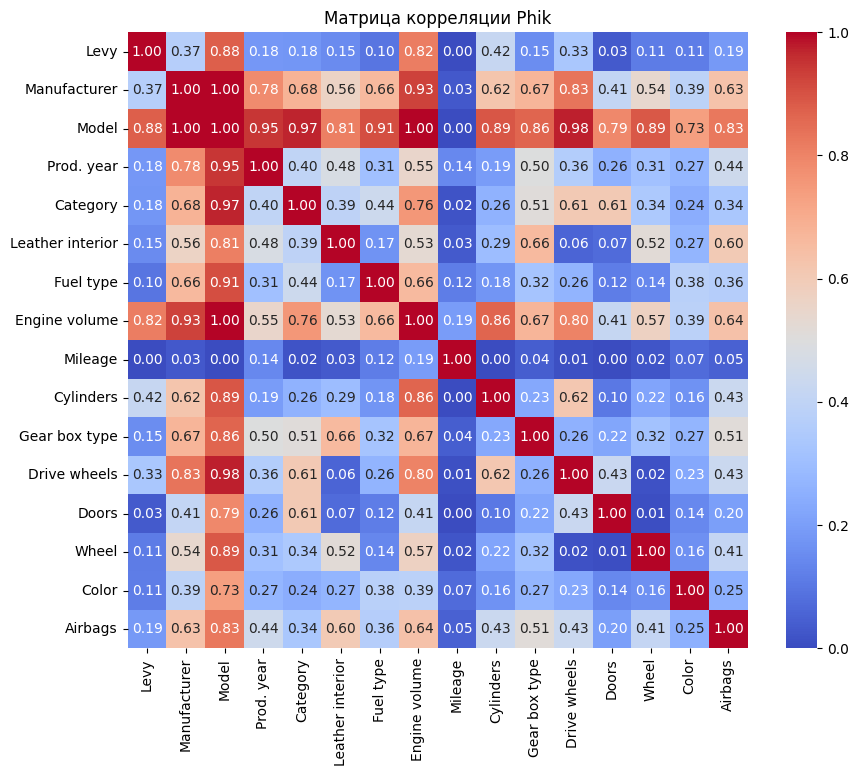

In [24]:
#Построим матрицу корреляций
phik_matrix = new_df.phik_matrix()

plt.figure(figsize=(10,8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляции Phik")
plt.show()
#заметим что достаточно много признаков коррелируют друг с другом, но главный тиз них это модель автомобиля которая коррелирует со всем остальным


In [25]:
X = df.drop('Price', axis=1)#Разделяем данные на таргет и признаки
y = df['Price']
print(X.head(10).to_string())
print(y.head(10))

   Levy Manufacturer     Model  Prod. year   Category Leather interior Fuel type Engine volume  Mileage  Cylinders Gear box type Drive wheels   Doors             Wheel   Color  Airbags
0  1399        LEXUS    RX 450        2010       Jeep              Yes    Hybrid           3.5   186005        6.0     Automatic          4x4  04-May        Left wheel  Silver       12
1  1018    CHEVROLET   Equinox        2011       Jeep               No    Petrol             3   192000        6.0     Tiptronic          4x4  04-May        Left wheel   Black        8
2     0        HONDA       FIT        2006  Hatchback               No    Petrol           1.3   200000        4.0      Variator        Front  04-May  Right-hand drive   Black        2
3   862         FORD    Escape        2011       Jeep              Yes    Hybrid           2.5   168966        4.0     Automatic          4x4  04-May        Left wheel   White        0
4   446        HONDA       FIT        2014  Hatchback              Yes    P

In [26]:
df['Doors'].value_counts()



Doors
04-May    18032
02-Mar      768
>5          124
Name: count, dtype: int64

In [27]:
def convert_doors(val):#ФУНКЦИЯ для преобразования признака doors к числовому
    val = str(val).strip()  
    if '-' in val:
        parts = val.split('-')
        try:
            return int(parts[0]) 
        except:
            return None  
    if val.startswith('>'):
        try:
            return int(val[1:]) + 1  
        except:
            return None
    try:
        return int(val)
    except:
        return None

In [28]:
X['Doors'] = X['Doors'].apply(convert_doors)


In [29]:
print(X['Doors'].value_counts())

Doors
4    18032
2      768
6      124
Name: count, dtype: int64


In [30]:
X['is_turbo'] = X['Engine volume'].str.contains('Turbo', case=False, na=False).astype(int)

X['engine_size'] = X['Engine volume'].str.extract(r'(\d+\.?\d*)').astype(float)

#Преобразуем признак в 2 столбца один числовой, второй бинарный который показывает есть ли турбо

In [31]:
print(X.head(10).to_string())
print(X['is_turbo'].unique())
X.drop('Engine volume', axis=1, inplace=True)


   Levy Manufacturer     Model  Prod. year   Category Leather interior Fuel type Engine volume  Mileage  Cylinders Gear box type Drive wheels  Doors             Wheel   Color  Airbags  is_turbo  engine_size
0  1399        LEXUS    RX 450        2010       Jeep              Yes    Hybrid           3.5   186005        6.0     Automatic          4x4      4        Left wheel  Silver       12         0          3.5
1  1018    CHEVROLET   Equinox        2011       Jeep               No    Petrol             3   192000        6.0     Tiptronic          4x4      4        Left wheel   Black        8         0          3.0
2     0        HONDA       FIT        2006  Hatchback               No    Petrol           1.3   200000        4.0      Variator        Front      4  Right-hand drive   Black        2         0          1.3
3   862         FORD    Escape        2011       Jeep              Yes    Hybrid           2.5   168966        4.0     Automatic          4x4      4        Left wheel   Whi

In [32]:
X['Leather interior']=X['Leather interior'].map({'Yes' : 1, 'No' : 0})
print(X['Leather interior'].unique())

[1 0]


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)#Делим датасет на треин и тест

In [34]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 15139 entries, 8727 to 16027
Series name: Price
Non-Null Count  Dtype
--------------  -----
15139 non-null  int64
dtypes: int64(1)
memory usage: 236.5 KB


In [35]:
X_train_preprocessed = X_train.copy()

In [36]:
categorical_cols = ['Manufacturer', 'Model', 'Category', 'Fuel type', 'Gear box type', 'Drive wheels', ' Wheel', 'Color']
numerical_cols = ['Levy', 'Prod. year', 'Mileage', 'Cylinders', 'Doors', 'Airbags', 'is_turbo',  'engine_size', 'Leather interior']

In [37]:
print(df['Manufacturer'].nunique(), df['Model'].nunique())

65 1590


In [38]:
print(df['Engine volume'].unique())

['3.5' '3' '1.3' '2.5' '2' '1.8' '2.4' '4' '1.6' '3.3' '2.0 Turbo'
 '2.2 Turbo' '4.7' '1.5' '4.4' '3.0 Turbo' '1.4 Turbo' '3.6' '2.3'
 '1.5 Turbo' '1.6 Turbo' '2.2' '2.3 Turbo' '1.4' '5.5' '2.8 Turbo' '3.2'
 '3.8' '4.6' '1.2' '5' '1.7' '2.9' '0.5' '1.8 Turbo' '2.4 Turbo'
 '3.5 Turbo' '1.9' '2.7' '4.8' '5.3' '0.4' '2.8' '3.2 Turbo' '1.1' '2.1'
 '0.7' '5.4' '1.3 Turbo' '3.7' '1' '2.5 Turbo' '2.6' '1.9 Turbo'
 '4.4 Turbo' '4.7 Turbo' '0.8' '0.2 Turbo' '5.7' '4.8 Turbo' '4.6 Turbo'
 '6.7' '6.2' '1.2 Turbo' '3.4' '1.7 Turbo' '6.3 Turbo' '2.7 Turbo' '4.3'
 '4.2' '2.9 Turbo' '0' '4.0 Turbo' '20' '3.6 Turbo' '0.3' '3.7 Turbo'
 '5.9' '5.5 Turbo' '0.2' '2.1 Turbo' '5.6' '6' '0.7 Turbo' '0.6 Turbo'
 '6.8' '4.5' '0.6' '7.3' '0.1' '1.0 Turbo' '6.3' '4.5 Turbo' '0.8 Turbo'
 '4.2 Turbo' '3.1' '5.0 Turbo' '6.4' '3.9' '5.7 Turbo' '0.9' '0.4 Turbo'
 '5.4 Turbo' '0.3 Turbo' '5.2' '5.8' '1.1 Turbo']


In [39]:
print(df['Color'].nunique())

16


In [40]:
print(X.head(10).to_string())

   Levy Manufacturer     Model  Prod. year   Category  Leather interior Fuel type  Mileage  Cylinders Gear box type Drive wheels  Doors             Wheel   Color  Airbags  is_turbo  engine_size
0  1399        LEXUS    RX 450        2010       Jeep                 1    Hybrid   186005        6.0     Automatic          4x4      4        Left wheel  Silver       12         0          3.5
1  1018    CHEVROLET   Equinox        2011       Jeep                 0    Petrol   192000        6.0     Tiptronic          4x4      4        Left wheel   Black        8         0          3.0
2     0        HONDA       FIT        2006  Hatchback                 0    Petrol   200000        4.0      Variator        Front      4  Right-hand drive   Black        2         0          1.3
3   862         FORD    Escape        2011       Jeep                 1    Hybrid   168966        4.0     Automatic          4x4      4        Left wheel   White        0         0          2.5
4   446        HONDA       FIT

In [40]:
categorical_cols_ordinal = ['Manufacturer', 'Model', 'Color']
categorical_cols_one_hot = ['Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel']

In [ ]:
categorical_cols_target = ['Manufacturer', 'Model', 'Color']#Делим категориальные признаки по тому как будем их кодировать
categorical_cols_one_hot = ['Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel']

In [ ]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [92]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_encoder = TargetEncoder(handle_unknown='use_encoded_value',handle_missing='value')

In [ ]:
y_train_log = np.log1p(y_train)#Попробуем обучать модели используя лог таргет тк имеется очень большой разброс в данных

In [93]:
#Обрабатываем категориальные признаки
preprocessor_trans = ColumnTransformer(
    transformers=[
        ('tar', target_encoder, categorical_cols_target),
        ('one_hot', one_hot_encoder, categorical_cols_one_hot)
    ],
    remainder='passthrough'
)

In [94]:
preprocessor_pipline = Pipeline([
    ('preprocessor', preprocessor_trans)
])

In [ ]:
#Обучаем пайплайн на треин модели(обрабатываем категориальные признаки)
X_train_preprocessed = preprocessor_pipline.fit_transform(X_train, y_train_log)

ord_columns = categorical_cols_target
ohe_columns = preprocessor_trans.named_transformers_['one_hot'].get_feature_names_out(categorical_cols_one_hot)
all_columns = preprocessor_pipline.get_feature_names_out()

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, index=X_train.index, columns=all_columns)

In [96]:
print(X_train_preprocessed.head(10).to_string())

       tar__Manufacturer  tar__Model  tar__Color  one_hot__Category_Cabriolet  one_hot__Category_Coupe  one_hot__Category_Goods wagon  one_hot__Category_Hatchback  one_hot__Category_Jeep  one_hot__Category_Limousine  one_hot__Category_Microbus  one_hot__Category_Minivan  one_hot__Category_Pickup  one_hot__Category_Sedan  one_hot__Category_Universal  one_hot__Fuel type_CNG  one_hot__Fuel type_Diesel  one_hot__Fuel type_Hybrid  one_hot__Fuel type_Hydrogen  one_hot__Fuel type_LPG  one_hot__Fuel type_Petrol  one_hot__Fuel type_Plug-in Hybrid  one_hot__Gear box type_Automatic  one_hot__Gear box type_Manual  one_hot__Gear box type_Tiptronic  one_hot__Gear box type_Variator  one_hot__Drive wheels_4x4  one_hot__Drive wheels_Front  one_hot__Drive wheels_Rear  one_hot__Wheel_Left wheel  one_hot__Wheel_Right-hand drive  remainder__Levy  remainder__Prod. year  remainder__Leather interior  remainder__Mileage  remainder__Cylinders  remainder__Doors  remainder__Airbags  remainder__is_turbo  remainder

In [97]:
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15139 entries, 8727 to 16027
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tar__Manufacturer                  15139 non-null  float64
 1   tar__Model                         15139 non-null  float64
 2   tar__Color                         15139 non-null  float64
 3   one_hot__Category_Cabriolet        15139 non-null  float64
 4   one_hot__Category_Coupe            15139 non-null  float64
 5   one_hot__Category_Goods wagon      15139 non-null  float64
 6   one_hot__Category_Hatchback        15139 non-null  float64
 7   one_hot__Category_Jeep             15139 non-null  float64
 8   one_hot__Category_Limousine        15139 non-null  float64
 9   one_hot__Category_Microbus         15139 non-null  float64
 10  one_hot__Category_Minivan          15139 non-null  float64
 11  one_hot__Category_Pickup           15139 non-null  float

In [ ]:
X_test_preprocessed = preprocessor_pipline.transform(X_test)#Применяем наш пайплан для тестовой модели


In [ ]:
ord_columns = categorical_cols_target
ohe_columns = preprocessor_trans.named_transformers_['one_hot'].get_feature_names_out(categorical_cols_one_hot)
all_columns = preprocessor_pipline.get_feature_names_out()


global_mean = y_train.mean()
X_test_preprocessed = pd.DataFrame(
    X_test_preprocessed, 
    index=X_test.index, 
    columns=all_columns
).fillna(global_mean)  


print(X_test_preprocessed.head().to_string())
#Заменяем пропуски на тестовых данных которые образовались после таргет кодирования к названию модели


      tar__Manufacturer  tar__Model  tar__Color  one_hot__Category_Cabriolet  one_hot__Category_Coupe  one_hot__Category_Goods wagon  one_hot__Category_Hatchback  one_hot__Category_Jeep  one_hot__Category_Limousine  one_hot__Category_Microbus  one_hot__Category_Minivan  one_hot__Category_Pickup  one_hot__Category_Sedan  one_hot__Category_Universal  one_hot__Fuel type_CNG  one_hot__Fuel type_Diesel  one_hot__Fuel type_Hybrid  one_hot__Fuel type_Hydrogen  one_hot__Fuel type_LPG  one_hot__Fuel type_Petrol  one_hot__Fuel type_Plug-in Hybrid  one_hot__Gear box type_Automatic  one_hot__Gear box type_Manual  one_hot__Gear box type_Tiptronic  one_hot__Gear box type_Variator  one_hot__Drive wheels_4x4  one_hot__Drive wheels_Front  one_hot__Drive wheels_Rear  one_hot__Wheel_Left wheel  one_hot__Wheel_Right-hand drive  remainder__Levy  remainder__Prod. year  remainder__Leather interior  remainder__Mileage  remainder__Cylinders  remainder__Doors  remainder__Airbags  remainder__is_turbo  remainder_

In [103]:
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15139 entries, 8727 to 16027
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tar__Manufacturer                  15139 non-null  float64
 1   tar__Model                         15139 non-null  float64
 2   tar__Color                         15139 non-null  float64
 3   one_hot__Category_Cabriolet        15139 non-null  float64
 4   one_hot__Category_Coupe            15139 non-null  float64
 5   one_hot__Category_Goods wagon      15139 non-null  float64
 6   one_hot__Category_Hatchback        15139 non-null  float64
 7   one_hot__Category_Jeep             15139 non-null  float64
 8   one_hot__Category_Limousine        15139 non-null  float64
 9   one_hot__Category_Microbus         15139 non-null  float64
 10  one_hot__Category_Minivan          15139 non-null  float64
 11  one_hot__Category_Pickup           15139 non-null  float

In [104]:
X_test_preprocessed['tar__Model'].isnull().sum()


np.int64(0)

In [105]:
########################################## BASELINE LINEAR REGRASSION ##########################################################
line_reg = LinearRegression()
line_reg.fit(X_train_preprocessed, y_train)

y_pred = line_reg.predict(X_test_preprocessed)

print('MAE= ', mean_absolute_error(y_test, y_pred))
print('MSE= ', mean_squared_error(y_test, y_pred))
print('R2= ', r2_score(y_test, y_pred))

MAE=  12471538.694086125
MSE=  2830697341640479.0
R2=  -8175812.751179083


In [106]:
########################################## BASELINE RANDOM FOREST ##########################################################
rf = RandomForestRegressor(random_state=SEED, n_estimators=100)

rf.fit(X_train_preprocessed, y_train)

y_pred = rf.predict(X_test_preprocessed)

print('MAE= ', mean_absolute_error(y_test, y_pred))
print('MSE= ', mean_squared_error(y_test, y_pred))
print('R2= ', r2_score(y_test, y_pred))



MAE=  6179.7411382698
MSE=  3477518859.258082
R2=  -9.044007916801815


In [107]:
rf_importance = pd.Series(rf.feature_importances_, index=X_train_preprocessed.columns).sort_values(ascending=False)

rf_importance_percent = (rf_importance / rf_importance.sum()) * 100

print(rf_importance_percent)



remainder__Mileage                   2.252212e+01
remainder__Prod. year                1.790160e+01
tar__Model                           1.058348e+01
remainder__engine_size               8.331853e+00
remainder__is_turbo                  7.277408e+00
tar__Color                           6.937975e+00
remainder__Airbags                   5.951947e+00
tar__Manufacturer                    3.580397e+00
remainder__Levy                      2.630919e+00
one_hot__Fuel type_Diesel            2.590203e+00
remainder__Cylinders                 2.416914e+00
one_hot__Gear box type_Tiptronic     1.939354e+00
one_hot__Category_Universal          1.333872e+00
one_hot__Drive wheels_Rear           8.499248e-01
remainder__Doors                     8.358826e-01
one_hot__Gear box type_Automatic     7.250470e-01
one_hot__Fuel type_Petrol            7.155310e-01
one_hot__Category_Jeep               4.592631e-01
one_hot__Drive wheels_Front          4.552925e-01
one_hot__Category_Goods wagon        4.361510e-01


In [116]:
########################################## BASELINE GRADIENT BOOSTING ##########################################################
gd = GradientBoostingRegressor(random_state=SEED)

gd.fit(X_train_preprocessed, y_train)

y_pred = gd.predict(X_test_preprocessed)

print('MAE= ', mean_absolute_error(y_test, y_pred))
print('MSE= ', mean_squared_error(y_test, y_pred))
print('R2= ', r2_score(y_test, y_pred))

MAE=  12249.950139974011
MSE=  9195039349.944702
R2=  -25.557741816489383


In [109]:

gd_importance = pd.Series(gd.feature_importances_, index=X_train_preprocessed.columns).sort_values(ascending=False)


gd_importance_percent = (gd_importance / gd_importance.sum()) * 100

print(gd_importance_percent)


remainder__Mileage                   42.440579
remainder__Prod. year                12.614417
remainder__Doors                     10.305816
remainder__Airbags                    9.449391
one_hot__Category_Goods wagon         9.038033
one_hot__Fuel type_Diesel             5.944033
remainder__engine_size                4.684925
tar__Model                            3.288138
tar__Color                            1.849655
tar__Manufacturer                     0.159473
remainder__is_turbo                   0.102505
one_hot__Gear box type_Tiptronic      0.036031
remainder__Cylinders                  0.026332
one_hot__Category_Universal           0.024562
remainder__Levy                       0.018583
one_hot__Gear box type_Automatic      0.006536
one_hot__Category_Jeep                0.003912
one_hot__Drive wheels_4x4             0.003773
one_hot__Category_Sedan               0.001748
one_hot__Category_Microbus            0.000792
one_hot__Drive wheels_Rear            0.000287
one_hot__Cate

In [110]:
print(X_train_preprocessed.head().to_string())

      tar__Manufacturer  tar__Model  tar__Color  one_hot__Category_Cabriolet  one_hot__Category_Coupe  one_hot__Category_Goods wagon  one_hot__Category_Hatchback  one_hot__Category_Jeep  one_hot__Category_Limousine  one_hot__Category_Microbus  one_hot__Category_Minivan  one_hot__Category_Pickup  one_hot__Category_Sedan  one_hot__Category_Universal  one_hot__Fuel type_CNG  one_hot__Fuel type_Diesel  one_hot__Fuel type_Hybrid  one_hot__Fuel type_Hydrogen  one_hot__Fuel type_LPG  one_hot__Fuel type_Petrol  one_hot__Fuel type_Plug-in Hybrid  one_hot__Gear box type_Automatic  one_hot__Gear box type_Manual  one_hot__Gear box type_Tiptronic  one_hot__Gear box type_Variator  one_hot__Drive wheels_4x4  one_hot__Drive wheels_Front  one_hot__Drive wheels_Rear  one_hot__Wheel_Left wheel  one_hot__Wheel_Right-hand drive  remainder__Levy  remainder__Prod. year  remainder__Leather interior  remainder__Mileage  remainder__Cylinders  remainder__Doors  remainder__Airbags  remainder__is_turbo  remainder_

In [152]:
#Сделали список моделей для обучения всех сразу на одних и тех же данных
model = [
    ('LinearRegression', LinearRegression()),
    ('RandomForest', RandomForestRegressor(random_state=SEED)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=SEED))
]

results = evaluate_models_cv_regression(model, X_train_preprocessed, y_train, cv=5, seed=SEED)


Кросс-валидация модели: LinearRegression
R2 (log):   -0.8457
MSE (log):  46448763642.2936
MAE (log):  15146.2822
RMSE (log): 119145.0160

Кросс-валидация модели: RandomForest
R2 (log):   -124.0353
MSE (log):  98281331635.0261
MAE (log):  11745.2324
RMSE (log): 277517.5716

Кросс-валидация модели: GradientBoosting
R2 (log):   -62.8208
MSE (log):  77038157211.6687
MAE (log):  14156.2392
RMSE (log): 219228.1015

=== Сводная таблица метрик (усреднённые по CV) ===
                    R2_log           MSE_log     MAE_log     RMSE_log
LinearRegression   -0.8457 -46448763642.2936 -15146.2822 -119145.0160
GradientBoosting  -62.8208 -77038157211.6687 -14156.2392 -219228.1015
RandomForest     -124.0353 -98281331635.0261 -11745.2324 -277517.5716


In [112]:
print(X_train_preprocessed.head(10).to_string())

       tar__Manufacturer  tar__Model  tar__Color  one_hot__Category_Cabriolet  one_hot__Category_Coupe  one_hot__Category_Goods wagon  one_hot__Category_Hatchback  one_hot__Category_Jeep  one_hot__Category_Limousine  one_hot__Category_Microbus  one_hot__Category_Minivan  one_hot__Category_Pickup  one_hot__Category_Sedan  one_hot__Category_Universal  one_hot__Fuel type_CNG  one_hot__Fuel type_Diesel  one_hot__Fuel type_Hybrid  one_hot__Fuel type_Hydrogen  one_hot__Fuel type_LPG  one_hot__Fuel type_Petrol  one_hot__Fuel type_Plug-in Hybrid  one_hot__Gear box type_Automatic  one_hot__Gear box type_Manual  one_hot__Gear box type_Tiptronic  one_hot__Gear box type_Variator  one_hot__Drive wheels_4x4  one_hot__Drive wheels_Front  one_hot__Drive wheels_Rear  one_hot__Wheel_Left wheel  one_hot__Wheel_Right-hand drive  remainder__Levy  remainder__Prod. year  remainder__Leather interior  remainder__Mileage  remainder__Cylinders  remainder__Doors  remainder__Airbags  remainder__is_turbo  remainder

In [ ]:
X_train_preprocessed_normalized = X_train_preprocessed.copy()

num_cols = ['remainder__Mileage', 'remainder__Levy']

# Нормализуем признаки чтобы не было большого разброса
scaler = StandardScaler()
X_train_preprocessed_normalized[num_cols] = scaler.fit_transform(X_train_preprocessed_normalized[num_cols])

In [118]:
results_normilizes = evaluate_models_cv_regression(models, X_train_preprocessed_normalized, y_train, cv=5, seed=SEED)


Кросс-валидация модели: LinearRegression
R2 (log):   -0.8457
MSE (log):  46448763641.5753
MAE (log):  15146.2822
RMSE (log): 119145.0160

Кросс-валидация модели: RandomForest
R2 (log):   -124.0353
MSE (log):  98281328848.7984
MAE (log):  11745.3600
RMSE (log): 277517.5699

Кросс-валидация модели: GradientBoosting
R2 (log):   -62.8208
MSE (log):  77038157211.6687
MAE (log):  14156.2392
RMSE (log): 219228.1015

=== Сводная таблица метрик (усреднённые по CV) ===
                    R2_log           MSE_log     MAE_log     RMSE_log
LinearRegression   -0.8457 -46448763641.5753 -15146.2822 -119145.0160
GradientBoosting  -62.8208 -77038157211.6687 -14156.2392 -219228.1015
RandomForest     -124.0353 -98281328848.7984 -11745.3600 -277517.5699


In [119]:
compare_regression_metrics(results, results_normilizes)


=== Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔR2_log (Variant 2-Variant 1)  ΔMSE_log (Variant 2-Variant 1)  ΔMAE_log (Variant 2-Variant 1)  ΔRMSE_log (Variant 2-Variant 1)
Model                                                                                                                                           
LinearRegression                         0.0000                          0.7183                          0.0000                           0.0000
GradientBoosting                         0.0000                          0.0000                          0.0000                           0.0000
RandomForest                             0.0000                       2786.2277                         -0.1276                           0.0016


,ΔR2_log (Variant 2-Variant 1),ΔMSE_log (Variant 2-Variant 1),ΔMAE_log (Variant 2-Variant 1),ΔRMSE_log (Variant 2-Variant 1)
Model,,,,
LinearRegression,7.210741e-09,0.718315,0.000039,0.000048
GradientBoosting,0.000000e+00,0.000000,0.000000,0.000000
RandomForest,7.523928e-06,2786.227692,-0.127642,0.001616


In [120]:
X_train_preprocessed.describe()

,tar__Manufacturer,tar__Model,tar__Color,one_hot__Category_Cabriolet,one_hot__Category_Coupe,one_hot__Category_Goods wagon,one_hot__Category_Hatchback,one_hot__Category_Jeep,one_hot__Category_Limousine,one_hot__Category_Microbus,...,one_hot__Wheel_Right-hand drive,remainder__Levy,remainder__Prod. year,remainder__Leather interior,remainder__Mileage,remainder__Cylinders,remainder__Doors,remainder__Airbags,remainder__is_turbo,remainder__engine_size
count,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,...,15139.000000,15139.000000,15139.000000,15139.000000,1.513900e+04,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000
mean,9.031306,9.000279,9.030362,0.001387,0.027545,0.012418,0.145386,0.285422,0.000661,0.016117,...,0.076689,631.604597,2010.918555,0.726798,1.501842e+06,4.580421,3.931171,6.565955,0.100139,2.306790
std,0.410583,0.612302,0.101240,0.037220,0.163670,0.110747,0.352501,0.451630,0.025693,0.125931,...,0.266107,558.771853,5.607703,0.445618,4.647320e+07,1.203027,0.432853,4.317732,0.300195,0.870305
min,8.237552,7.515405,8.602354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1939.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000,0.000000,0.000000
25%,8.752792,8.552414,8.981735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2009.000000,0.000000,7.000000e+04,4.000000,4.000000,4.000000,0.000000,1.800000
50%,8.902424,9.032137,9.037736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,642.000000,2012.000000,1.000000,1.264100e+05,4.000000,4.000000,6.000000,0.000000,2.000000
75%,9.227228,9.299658,9.079348,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,915.000000,2015.000000,1.000000,1.895300e+05,4.000000,4.000000,12.000000,0.000000,2.500000
max,10.246605,10.372583,9.689827,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,11714.000000,2020.000000,1.000000,2.147484e+09,16.000000,6.000000,16.000000,1.000000,20.000000


In [121]:
X_train_preprocessed['remainder__Levy'].value_counts()

remainder__Levy
0.0       4583
765.0      397
891.0      355
639.0      329
640.0      326
          ... 
2705.0       1
1357.0       1
748.0        1
3699.0       1
3989.0       1
Name: count, Length: 526, dtype: int64

In [ ]:
#Добавили новые признаки такие как сколько лет машине пробег в год и тд
X_train_preprocessed_new = X_train_preprocessed.copy()
X_train_preprocessed_new["car_age"] = 2025 - X_train_preprocessed_new["remainder__Prod. year"]
X_train_preprocessed_new["mileage_per_year"] = X_train_preprocessed_new["remainder__Mileage"] / X_train_preprocessed_new["car_age"].replace(0, 1)
X_train_preprocessed_new["volume_per_cyl"] = X_train_preprocessed_new["remainder__engine_size"] / X_train_preprocessed_new["remainder__Cylinders"].replace(0, 1)
X_train_preprocessed_new["mileage_group"] = pd.cut(X_train_preprocessed_new["remainder__Mileage"], bins=[0, 50000, 100000, 200000, 300000, np.inf],
                             labels=[0,1,2,3,4], include_lowest=True)

In [123]:
X_train_preprocessed_new.isnull().sum()

tar__Manufacturer                    0
tar__Model                           0
tar__Color                           0
one_hot__Category_Cabriolet          0
one_hot__Category_Coupe              0
one_hot__Category_Goods wagon        0
one_hot__Category_Hatchback          0
one_hot__Category_Jeep               0
one_hot__Category_Limousine          0
one_hot__Category_Microbus           0
one_hot__Category_Minivan            0
one_hot__Category_Pickup             0
one_hot__Category_Sedan              0
one_hot__Category_Universal          0
one_hot__Fuel type_CNG               0
one_hot__Fuel type_Diesel            0
one_hot__Fuel type_Hybrid            0
one_hot__Fuel type_Hydrogen          0
one_hot__Fuel type_LPG               0
one_hot__Fuel type_Petrol            0
one_hot__Fuel type_Plug-in Hybrid    0
one_hot__Gear box type_Automatic     0
one_hot__Gear box type_Manual        0
one_hot__Gear box type_Tiptronic     0
one_hot__Gear box type_Variator      0
one_hot__Drive wheels_4x4

In [124]:
len(X_train_preprocessed[X_train_preprocessed['remainder__Mileage']==0])#Проверяем на корректность данных некоторые признаки

583

In [73]:
results_new = evaluate_models_cv_regression(models, X_train_preprocessed_new, y_train, cv=5, seed=SEED)


Кросс-валидация модели: LinearRegression
R2:   -0.9016
MSE:  46461659079.5856
MAE:  16114.0196
RMSE: 119521.8286

Кросс-валидация модели: RandomForest
R2:   -167.7701
MSE:  113974494695.2132
MAE:  12162.6477
RMSE: 288157.6826

Кросс-валидация модели: GradientBoosting
R2:   -87.7598
MSE:  86300081075.3720
MAE:  15528.4892
RMSE: 268210.3248

=== Сводная таблица метрик (усреднённые по CV) ===
                        R2                MSE         MAE         RMSE
LinearRegression   -0.9016  -46461659079.5856 -16114.0196 -119521.8286
GradientBoosting  -87.7598  -86300081075.3720 -15528.4892 -268210.3248
RandomForest     -167.7701 -113974494695.2132 -12162.6477 -288157.6826


In [74]:
print(len(X_train_preprocessed_new), len(y_train))
print(X_train_preprocessed_new.index.equals(y_train.index))

15139 15139
True


(array([1.5138e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.63075090e+06, 5.26150080e+06, 7.89225070e+06,
        1.05230006e+07, 1.31537505e+07, 1.57845004e+07, 1.84152503e+07,
        2.10460002e+07, 2.36767501e+07, 2.63075000e+07]),
 <BarContainer object of 10 artists>)

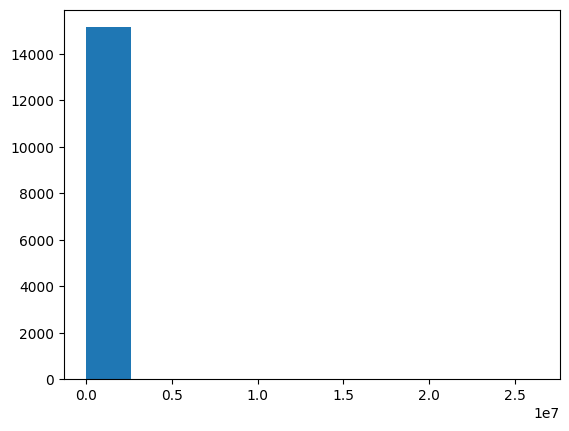

In [76]:
y_train.describe()
y_train.isna().sum()
plt.hist(y_train, bins=10)


NaN в y_train: 0
count    1.513900e+04
mean     1.892078e+04
std      2.146141e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.200000e+04
max      2.630750e+07
Name: Price, dtype: float64

Минимум: 1
Максимум: 26307500

Квантили:
0.00        1.0
0.25     5331.0
0.50    13172.0
0.75    22000.0
0.90    38732.2
0.95    49237.0
0.99    83107.0
Name: Price, dtype: float64


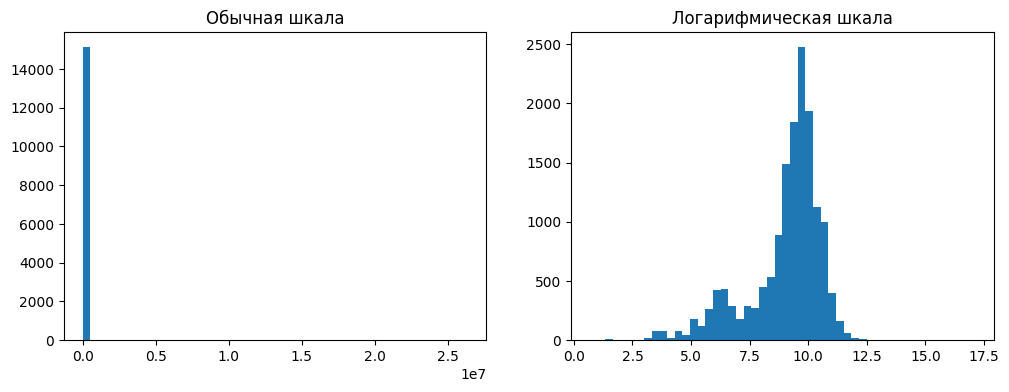

In [ ]:
#Смотрим на масштаб таргет переменной обычной и если применить логарифм
print("NaN в y_train:", y_train.isna().sum())
print(y_train.describe())

# Проверим уникальные диапазоны
print("\nМинимум:", y_train.min())
print("Максимум:", y_train.max())

# 1. Посмотрим квантильное распределение
print("\nКвантили:")
print(y_train.quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# 2. Нарисуем две гистограммы: обычную и в логарифмической шкале
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(y_train, bins=50)
ax[0].set_title("Обычная шкала")

ax[1].hist(np.log1p(y_train), bins=50)
ax[1].set_title("Логарифмическая шкала")
plt.show()


In [ ]:
y_train_log = np.log1p(y_train)#Попробуем обучить модель на лог таргете чтобы не было таких огромных выбросов


In [114]:
print(y_train)

8727     40976
4808       941
579      75266
8139     12544
6554       941
         ...  
11413    18817
12106     8938
5429      2509
861      18817
16027     5488
Name: Price, Length: 15139, dtype: int64


In [125]:
results_new = evaluate_models_cv_regression(models, X_train_preprocessed_new, y_train, cv=5, seed=SEED, log=True)


Кросс-валидация модели: LinearRegression
R2 (log):   0.2949
MSE (log):  1.7633
MAE (log):  0.9282
RMSE (log): 1.3278
R2 (real):   0.0011
MSE (real):  46007087714.3012
MAE (real):  11136.9934
RMSE (real): 214492.6286
MAPE (real): 846.27%
SMAPE (real): 73.11%

Кросс-валидация модели: RandomForest
R2 (log):   0.6475
MSE (log):  0.8815
MAE (log):  0.4775
RMSE (log): 0.9388
R2 (real):   0.0042
MSE (real):  45863861589.5881
MAE (real):  6591.5857
RMSE (real): 214158.4964
MAPE (real): 645.20%
SMAPE (real): 38.04%

Кросс-валидация модели: GradientBoosting
R2 (log):   0.4749
MSE (log):  1.3132
MAE (log):  0.7436
RMSE (log): 1.1459
R2 (real):   0.0026
MSE (real):  45935445981.5176
MAE (real):  9014.2563
RMSE (real): 214325.5607
MAPE (real): 698.15%
SMAPE (real): 60.03%

=== Сводная таблица метрик (усреднённые по CV) ===
                  R2_log  MSE_log  MAE_log  RMSE_log   MAE_real         MSE_real   RMSE_real  R2_real  MAPE_real  SMAPE_real
RandomForest      0.6475  -0.8815  -0.4775   -0.9388

In [127]:
pd.options.display.float_format = '{:,.0f}'.format


In [ ]:
y_train.describe(percentiles=[0.9, 0.95, 0.99, 0.999])#Смотрим на распределенгие данных и видим что есть огромные выбросы после 99 перцентиля


count       15,139
mean        18,921
std        214,614
min              1
50%         13,172
90%         38,732
95%         49,237
99%         83,107
99.9%      172,486
max     26,307,500
Name: Price, dtype: float64

In [ ]:
#Убираем выбросы которые находятся выше 99 перцентился чтобы не портили нашу модель и слишком сильно не подстраивались под отгромные выбросы
mask = y_train <= y_train.quantile(0.99)
y_train_filtered = y_train[mask]
X_train_preprocessed_filtered = X_train_preprocessed[mask]


In [ ]:
results_new = evaluate_models_cv_regression(models, X_train_preprocessed_filtered, y_train_filtered, cv=5, seed=SEED, log=True)#Видим чсильное улучшение результата после отброса выбросов и использование лог таргета


Кросс-валидация модели: LinearRegression
R2 (log):   0.2823
MSE (log):  1.7587
MAE (log):  0.9281
RMSE (log): 1.3261
R2 (real):   0.1685
MSE (real):  179566725.7414
MAE (real):  8631.6709
RMSE (real): 13400.2510
MAPE (real): 819.53%
SMAPE (real): 73.10%

Кросс-валидация модели: RandomForest
R2 (log):   0.6415
MSE (log):  0.8784
MAE (log):  0.4741
RMSE (log): 0.9371
R2 (real):   0.7079
MSE (real):  63087041.1566
MAE (real):  4260.0313
RMSE (real): 7942.7351
MAPE (real): 640.66%
SMAPE (real): 37.71%

Кросс-валидация модели: GradientBoosting
R2 (log):   0.4700
MSE (log):  1.2987
MAE (log):  0.7404
RMSE (log): 1.1396
R2 (real):   0.4318
MSE (real):  122708884.8863
MAE (real):  6630.8740
RMSE (real): 11077.4042
MAPE (real): 679.43%
SMAPE (real): 59.87%

=== Сводная таблица метрик (усреднённые по CV) ===
                  R2_log  MSE_log  MAE_log  RMSE_log  MAE_real       MSE_real  RMSE_real  R2_real  MAPE_real  SMAPE_real
RandomForest      0.6415  -0.8784  -0.4741   -0.9371 4260.0313  6308

In [131]:
X_train_preprocessed_new_filtered = X_train_preprocessed_new[mask]
results_new = evaluate_models_cv_regression(models, X_train_preprocessed_new_filtered, y_train_filtered, cv=5, seed=SEED, log=True)


Кросс-валидация модели: LinearRegression
R2 (log):   0.2849
MSE (log):  1.7524
MAE (log):  0.9253
RMSE (log): 1.3238
R2 (real):   0.1781
MSE (real):  177484351.0269
MAE (real):  8598.3658
RMSE (real): 13322.3253
MAPE (real): 829.81%
SMAPE (real): 72.92%

Кросс-валидация модели: RandomForest
R2 (log):   0.6423
MSE (log):  0.8765
MAE (log):  0.4747
RMSE (log): 0.9361
R2 (real):   0.7039
MSE (real):  63938346.0622
MAE (real):  4285.6577
RMSE (real): 7996.1457
MAPE (real): 637.86%
SMAPE (real): 37.80%

Кросс-валидация модели: GradientBoosting
R2 (log):   0.4672
MSE (log):  1.3055
MAE (log):  0.7432
RMSE (log): 1.1426
R2 (real):   0.4301
MSE (real):  123070894.0216
MAE (real):  6657.9752
RMSE (real): 11093.7322
MAPE (real): 675.47%
SMAPE (real): 60.08%

=== Сводная таблица метрик (усреднённые по CV) ===
                  R2_log  MSE_log  MAE_log  RMSE_log  MAE_real       MSE_real  RMSE_real  R2_real  MAPE_real  SMAPE_real
RandomForest      0.6423  -0.8765  -0.4747   -0.9361 4285.6577  6393

In [139]:
print(X_train_preprocessed_filtered.head(10).to_string())

       tar__Manufacturer  tar__Model  tar__Color  one_hot__Category_Cabriolet  one_hot__Category_Coupe  one_hot__Category_Goods wagon  one_hot__Category_Hatchback  one_hot__Category_Jeep  one_hot__Category_Limousine  one_hot__Category_Microbus  one_hot__Category_Minivan  one_hot__Category_Pickup  one_hot__Category_Sedan  one_hot__Category_Universal  one_hot__Fuel type_CNG  one_hot__Fuel type_Diesel  one_hot__Fuel type_Hybrid  one_hot__Fuel type_Hydrogen  one_hot__Fuel type_LPG  one_hot__Fuel type_Petrol  one_hot__Fuel type_Plug-in Hybrid  one_hot__Gear box type_Automatic  one_hot__Gear box type_Manual  one_hot__Gear box type_Tiptronic  one_hot__Gear box type_Variator  one_hot__Drive wheels_4x4  one_hot__Drive wheels_Front  one_hot__Drive wheels_Rear  one_hot__Wheel_Left wheel  one_hot__Wheel_Right-hand drive  remainder__Levy  remainder__Prod. year  remainder__Leather interior  remainder__Mileage  remainder__Cylinders  remainder__Doors  remainder__Airbags  remainder__is_turbo  remainder

In [ ]:
#Пробуем добавить лог признаки пробега и levy для нормализации данных, а также др преобразования
X_train_preprocessed_filtered_new = X_train_preprocessed_filtered.copy()
log_transformer = FunctionTransformer(np.log1p, validate=False)
X_train_preprocessed_filtered_new['Mileage_log'] = log_transformer.transform(X_train_preprocessed_filtered_new[['remainder__Mileage']])
X_train_preprocessed_filtered_new['Levy_log'] = log_transformer.transform(X_train_preprocessed_filtered_new[['remainder__Levy']])
X_train_preprocessed_filtered_new['car_age'] = 2025 - X_train_preprocessed_filtered_new['remainder__Prod. year']
X_train_preprocessed_filtered_new['mileage_per_year'] = X_train_preprocessed_filtered_new['remainder__Mileage'] / X_train_preprocessed_filtered_new['car_age']



In [ ]:
results_new = evaluate_models_cv_regression(models, X_train_preprocessed_filtered_new, y_train_filtered, cv=5, seed=SEED, log=True)#Результаты модели особо не изменились


Кросс-валидация модели: LinearRegression
R2 (log):   0.2857
MSE (log):  1.7506
MAE (log):  0.9248
RMSE (log): 1.3230
R2 (real):   0.1664
MSE (real):  180013534.7022
MAE (real):  8614.2142
RMSE (real): 13416.9123
MAPE (real): 845.83%
SMAPE (real): 72.91%

Кросс-валидация модели: RandomForest
R2 (log):   0.6428
MSE (log):  0.8752
MAE (log):  0.4739
RMSE (log): 0.9354
R2 (real):   0.7050
MSE (real):  63700100.6438
MAE (real):  4282.8789
RMSE (real): 7981.2343
MAPE (real): 647.45%
SMAPE (real): 37.73%

Кросс-валидация модели: GradientBoosting
R2 (log):   0.4689
MSE (log):  1.3013
MAE (log):  0.7412
RMSE (log): 1.1407
R2 (real):   0.4302
MSE (real):  123060071.6965
MAE (real):  6645.7478
RMSE (real): 11093.2444
MAPE (real): 678.19%
SMAPE (real): 59.94%

=== Сводная таблица метрик (усреднённые по CV) ===
                  R2_log  MSE_log  MAE_log  RMSE_log  MAE_real       MSE_real  RMSE_real  R2_real  MAPE_real  SMAPE_real
RandomForest      0.6428  -0.8752  -0.4739   -0.9354 4282.8789  6370

In [148]:
X_train_preprocessed_filtered_new_del = X_train_preprocessed_filtered_new.copy()
X_train_preprocessed_filtered_new_del.drop(['remainder__Mileage', 'remainder__Levy', 'remainder__Prod. year'], axis=1, inplace=True)

In [153]:
results_new_del = evaluate_models_cv_regression(model, X_train_preprocessed_filtered_new_del, y_train_filtered, cv=5, seed=SEED, log=True)#Результаты модели особо не изменились


Кросс-валидация модели: LinearRegression
R2 (log):   0.2863
MSE (log):  1.7489
MAE (log):  0.9247
RMSE (log): 1.3224
R2 (real):   0.1668
MSE (real):  179930475.2544
MAE (real):  8614.3257
RMSE (real): 13413.8166
MAPE (real): 835.19%
SMAPE (real): 72.91%

Кросс-валидация модели: RandomForest
R2 (log):   0.6430
MSE (log):  0.8748
MAE (log):  0.4740
RMSE (log): 0.9352
R2 (real):   0.7047
MSE (real):  63776456.0699
MAE (real):  4284.9732
RMSE (real): 7986.0163
MAPE (real): 636.91%
SMAPE (real): 37.75%

Кросс-валидация модели: GradientBoosting
R2 (log):   0.4688
MSE (log):  1.3016
MAE (log):  0.7413
RMSE (log): 1.1409
R2 (real):   0.4299
MSE (real):  123119371.3652
MAE (real):  6647.1238
RMSE (real): 11095.9169
MAPE (real): 678.20%
SMAPE (real): 59.94%

=== Сводная таблица метрик (усреднённые по CV) ===
                  R2_log  MSE_log  MAE_log  RMSE_log  MAE_real       MSE_real  RMSE_real  R2_real  MAPE_real  SMAPE_real
RandomForest      0.6430  -0.8748  -0.4740   -0.9352 4284.9732  6377

In [ ]:
#Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    }
}


In [147]:
best_models = {}

for name, config in models.items():
    print(f"=== {name} ===")
    gs = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1, 
        verbose=2
    )
    gs.fit(X_train_preprocessed_filtered, y_train_filtered)
    
    print("Best params:", gs.best_params_)
    print("Best MAE:", -gs.best_score_)
    
    best_models[name] = gs.best_estimator_

=== LinearRegression ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'fit_intercept': True}
Best MAE: 8309.21280119426
=== RandomForest ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best MAE: 3835.0058518955657
=== GradientBoosting ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best MAE: 3936.682956357753
